# Find the Best Model


---

In [192]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin

import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from pprint import pprint
from xgboost import XGBClassifier
import joblib


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:
from helpers import load_sqlite, custom_stop_words, get_random_class_labels, plot_confusion_matrix

In [194]:
random_state = 77

# labels = ['python','aws','datascience','machinelearning','dataengineering']
# list to get data for
labels = ['python','javascript','html']

df = load_sqlite(database='reddit.sqlite', class_labels=labels)

# what we expected?
df.sample(10)

,title,subreddit,date
2054,Loop on all elements of a dataframe - PySpark,python,2020-03-29
66406,How do I create instagram comment bot ?,python,2020-05-14
40021,Is a Redux Store Observable?,javascript,2020-05-02
24518,Statistics using python part 2 : explaining me...,python,2020-04-24
46788,"Desktop build for Python (numpy, scipy, pandas...",python,2020-05-07
1877,"Firefox Dev Tools Architecture, and How to Sta...",javascript,2020-03-29
50321,Struggles with placing images in the center of...,html,2020-05-11
10673,Made a SPOJ Problem Initialization script usin...,python,2020-04-14
1108,Deploying MERN stack application using mongo d...,javascript,2020-03-29
384,New to HTML/CSS what is this called and how ca...,html,2020-03-29


In [196]:
X = df['title']
y = df['subreddit']

In [197]:
y.value_counts()

python        4776
javascript    1996
html          1320
Name: subreddit, dtype: int64

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

In [199]:
X_train, y_train = resample_to_average(X_train, y_train, sample_method='max', random_state=random_state)

In [200]:
np.unique(y_train, return_counts=True)

(array(['html', 'javascript', 'python'], dtype=object),
 array([3569, 3569, 3569]))

In [201]:
labeler = LabelEncoder()
y_train = labeler.fit_transform(y_train)
y_test = labeler.transform(y_test)


In [202]:
tfidf = {
    'preprocessor': TfidfVectorizer(stop_words=custom_stop_words),
    'name': 'TF-IDF Vectorizer',
    'params': {
        "prep__ngram_range": [(1, 2)],
        "prep__max_df": [.9],
        "prep__use_idf": [True],
        "prep__norm": ["l2"]
    }
}

In [203]:
estimators = {
    "logisticregression": {
        "name": "Logistic Regression",
        "estimator": LogisticRegression(max_iter=1000, fit_intercept=False, C=.99),
        "params": {
            "clf__solver": ["lbfgs", "saga"]
        }
    },
    # "randomforestclassifier": {
    #     "name": "Random Forest",
    #     "estimator": RandomForestClassifier(min_samples_leaf=2, min_samples_split=.01),
    #     "params": {
    #         "clf__n_estimators": [300, 500, 1000],
    #         "clf__max_depth": np.linspace(400, 1000, 5, dtype=int)
    #     }
    # },
    "multinomialnb": {
        "name": "Multinomial Bayes Classifier",
        "estimator": MultinomialNB(alpha=.1189),
        "params": {
            "clf__fit_prior": [True, False]
        }
    },
    # "svc": {
    #     "name": "Support Vector Classifier",
    #     "estimator": SVC(kernel="sigmoid", probability=True),
    #     "params": {
    #         "clf__C": [.99, 1]
    #     }
    # },
    # "sgdclassifier": {
    #     "name": "Stochastic Gradient Descent Classifier",
    #     "estimator": SGDClassifier(alpha=.0001, fit_intercept=True, penalty="l2", loss="modified_huber"),
    #     "params":
    #         {
    #     }
    # },
    # 'xgbclassifier': {
    #     'name': 'XGBoost Classifier',
    #     'estimator': XGBClassifier(n_estimators=200),
    #     'params': {
    #         "clf__max_depth": [3, 5, 10],
    #         "clf__learning_rate": np.linspace(.001, .1, 3),
    #         "clf__n_estimators": [50, 100, 200],
    #         "clf__objective": ['binary:logistic', 'multi:softprob'],
    #         "clf__booster": ['gbtree', 'gblinear', 'dart'],
    #         "clf__gamma": np.linspace(0, 1, 3),
    #         "clf__subsample": [.5, 1],
    #         "clf__reg_lambda": np.linspace(0, 1, 3),
    #     }
    # }
}

In [204]:
def build_and_train_model(preprocessor, classifier, cv=3, verbose=1):
    '''
    Takes a dictionary with params and outputs a fitted model
    '''
    pipe = Pipeline(
    [('prep', preprocessor.get('preprocessor')),
     ('clf', classifier.get('estimator'))])
    
    pipe_params = dict()
    pipe_params.update(preprocessor.get('params'))
    pipe_params.update(classifier.get('params'))
    
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    model = GridSearchCV(pipe, param_grid=pipe_params, cv=skf, verbose=verbose, n_jobs=-1)
    model.fit(X_train, y_train)
    return model

**************************************************
Model: Logistic Regression

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    1.7s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.8s finished

Train Score: 0.9868310451106752
Test Score: 0.750370736529906
AUC Score: 0.9003820621108165

              precision    recall  f1-score   support

           0      0.558     0.762     0.645       320
           1      0.676     0.766     0.718       496
           2      0.873     0.741     0.801      1207

    accuracy                          0.750      2023
   macro avg      0.703     0.756     0.721      2023
weighted avg      0.775     0.750     0.756      2023



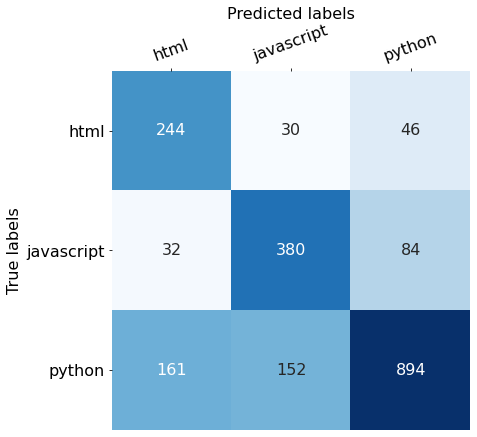



**************************************************
Model: Multinomial Bayes Classifier

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.0s finished

Train Score: 0.989726347249463
Test Score: 0.7320810677212062
AUC Score: 0.89624873614653

              precision    recall  f1-score   support

           0      0.570     0.772     0.656       320
           1      0.628     0.780     0.696       496
           2      0.870     0.702     0.777      1207

    accuracy                          0.732      2023
   macro avg      0.689     0.751     0.710      2023
weighted avg      0.763     0.732     0.738      2023



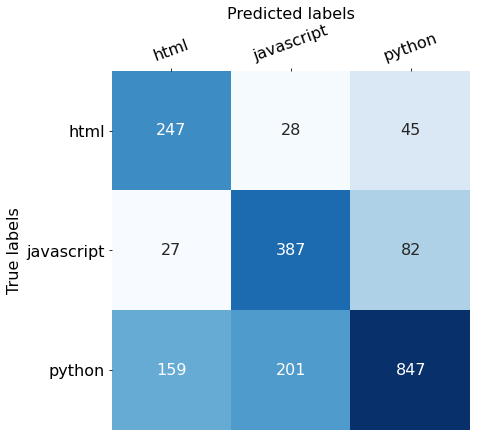

In [205]:
for name, estimator in estimators.items():
    
    print("*"*50)
    print(f'Model: {estimator.get("name")}')
    print()
    model = build_and_train_model(preprocessor=tfidf, classifier=estimator, cv=3, verbose=5)
    
    date = str(datetime.datetime.now().strftime('%Y-%m-%d_%H%M'))
    estimator_name = type(model.estimator.named_steps.clf).__name__
    # joblib_file = f'{estimator_name}_best_model_{date}.pkl'
    # joblib.dump(model, CONFIG.DATA_DIR / joblib_file)
    print()
    print(f'Train Score: {model.score(X_train, y_train)}')
    print(f'Test Score: {model.score(X_test, y_test)}')
    
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)
        print(f'AUC Score: {roc_auc_score(y_test, y_proba, multi_class="ovr")}')
    print()    
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))

    plot_confusion_matrix(model, y_test, y_pred, classes=labeler.classes_)
    # plt.savefig(CONFIG.DATA_DIR / f'{estimator_name}_confusion_matrix_{date}.png')
    plt.show()
    print()
    print()